# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

In [3]:
import pandas as pd
import numpy as np
import math
import json
import matplotlib.pyplot as plt
import seaborn as sb

from scipy import stats
% matplotlib inline

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

## Exploring the data sets
I wanted to have a look at the heads of each dataframe to see what they contained, and then pull some basic statistics from each one, just to get a feel of the data I would be working with, and an idea of what cleaning would be needed

In [4]:
portfolio.head()

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5


In [5]:
print(portfolio.shape)
print(portfolio.isna().sum())

(10, 6)
channels      0
difficulty    0
duration      0
id            0
offer_type    0
reward        0
dtype: int64


In [6]:
# Create dummy columns from channels
# Solution found at https://stackoverflow.com/questions/29034928/pandas-convert-a-column-of-list-to-dummies
portfolio = pd.concat([portfolio,pd.get_dummies(portfolio['channels'].apply(pd.Series).stack()).sum(level=0)],
                      axis=1)

In [7]:
portfolio.head()

,channels,difficulty,duration,id,offer_type,reward,email,mobile,social,web
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,1,1,1,0
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10,1,1,1,1
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0,1,1,0,1
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5,1,1,0,1
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5,1,0,0,1


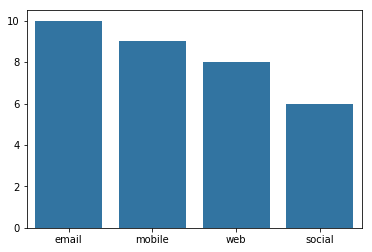

In [8]:
sums = portfolio[['email', 'mobile', 'social','web']].sum().sort_values(ascending=False)
sb.barplot(sums.index, sums.values, color=sb.color_palette()[0]);

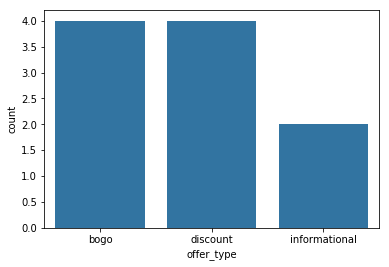

In [9]:
order = portfolio['offer_type'].value_counts().index
sb.countplot(data=portfolio, x='offer_type', color = sb.color_palette()[0], order=order);

In [10]:
portfolio.describe()

,difficulty,duration,reward,email,mobile,social,web
count,10.000000,10.000000,10.000000,10.0,10.000000,10.000000,10.000000
mean,7.700000,6.500000,4.200000,1.0,0.900000,0.600000,0.800000
std,5.831905,2.321398,3.583915,0.0,0.316228,0.516398,0.421637
min,0.000000,3.000000,0.000000,1.0,0.000000,0.000000,0.000000
25%,5.000000,5.000000,2.000000,1.0,1.000000,0.000000,1.000000
50%,8.500000,7.000000,4.000000,1.0,1.000000,1.000000,1.000000
75%,10.000000,7.000000,5.000000,1.0,1.000000,1.000000,1.000000
max,20.000000,10.000000,10.000000,1.0,1.000000,1.000000,1.000000


## Findings from the Portfolio Dataset

We can see that all of the offers are distributed via email, which makes this medium type irrelevant. There are no null values in the dataset at all. we can also see that BOGO and Discount offer types each make up 40% of the offers, with the remaining 20% being made up of informational. 

In [11]:
profile.head()

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


In [12]:
print(profile.shape)
print(profile.isna().sum())

(17000, 5)
age                    0
became_member_on       0
gender              2175
id                     0
income              2175
dtype: int64


In [13]:
print('number of "null" age: {}'.format(profile[profile['age']==118].count()[0]))

number of "null" age: 2175


In [14]:
#Are these all the same people, or is it just a massive coincidence that there are 2175 nulls in each column??
profile[profile['age']==118].count()

age                 2175
became_member_on    2175
gender                 0
id                  2175
income                 0
dtype: int64

### What to do with the null values
This shows that all the people that didn't supply an age, also didn't supply a gender or income. Everybody else supplied all the information. As this is a significant proportion of the population (2174 out of 17000), we can not discount them. It doesn't make sense to fill these null values with another value in this case as that will dilute the accuracy of any results we get quite significantly. It also ignores the fact that a certain type of person may chose not to provide any data about themselves. Instead it would be good to consider these as their own separate group, as there could be similarities with how they use/interact with offers. This will allow us to better understand any new users that also chose not to provide any data when signing up for the app.

In [15]:
#Set values for gender and income null values, ensuring they are unique so we can still highlight them later on
max_income = profile['income'].max()
nan_vals = {"gender":'U',
           "income": max_income+(max_income/10)}
profile.fillna(value=nan_vals, inplace=True)


In [16]:
def plot_bar_props(df, x_name, tick_intervals = 0.05, **kwargs):
    order=df[x_name].value_counts().index

    # calculate max proportion
    total=df[df[x_name].isna() == False].shape[0]
    max_count = df[x_name].value_counts()[0]
    max_prop = max_count/total

    # Create array of evenly spaced values
    tick_props = np.arange(0, max_prop+tick_intervals, tick_intervals)
    tick_names = ['{:0.2f}'.format(v) for v in tick_props]

    sb.countplot(data=df, x=x_name, order=order, **kwargs);
    plt.yticks(tick_props*total, tick_names);
    plt.ylabel('proportion');

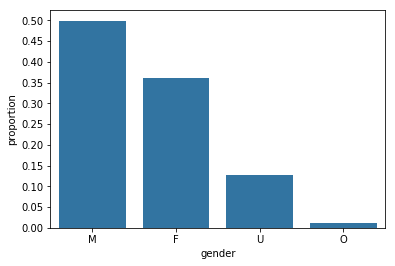

In [17]:
plot_bar_props(profile, 'gender', color = sb.color_palette()[0])

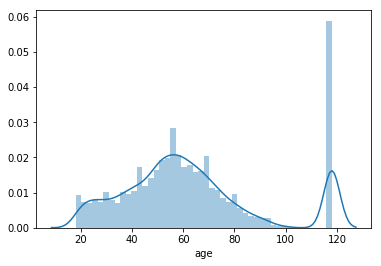

In [18]:
sb.distplot(a=profile[profile['age'].isna() == False]['age']);

In [19]:
transcript.head()

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


In [20]:
print(transcript.shape)
print(transcript.isna().sum())

(306534, 4)
event     0
person    0
time      0
value     0
dtype: int64


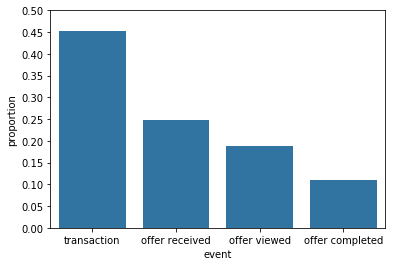

In [21]:
plot_bar_props(transcript, 'event', color = sb.color_palette()[0])

In [22]:
#Get the values from dictionary in value column
value_norm = pd.io.json.json_normalize(transcript['value'])
value_norm.head()

,amount,offer id,offer_id,reward
0,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN
1,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN
2,NaN,2906b810c7d4411798c6938adc9daaa5,NaN,NaN
3,NaN,fafdcd668e3743c1bb461111dcafc2a4,NaN,NaN
4,NaN,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,NaN


In [23]:
#could have used concat here, but I wanted to rename the columns at the same time, and this seemed the simplest way to do that
transcript['offer_id'] = value_norm['offer id']
transcript['completed_offer'] = value_norm['offer_id']
transcript['purchase_amount'] = value_norm['amount']
transcript['reward'] = value_norm['reward']
transcript.drop(['value'], inplace=True, axis=1)

In [24]:
#Create dummy columns from event
transcript.loc[transcript['event'] == 'offer received', 'offer_received'] = 1
transcript.loc[transcript['event'] == 'offer viewed', 'offer_viewed'] = 1
transcript.loc[transcript['event'] == 'offer completed', 'offer_completed'] = 1
#Move values in completed_offer into offer_id column, then drop completed_offer column as we no longer need this.
transcript.loc[transcript['completed_offer'].isna() == False, 'offer_id'] = transcript['completed_offer']
transcript.drop(['completed_offer'], inplace=True, axis=1)
transcript.fillna(value=0, inplace=True)

In [25]:
#Add offer data to transcript dataframe
portfolio = pd.get_dummies(data=portfolio, columns=['offer_type'])
transcript = transcript.join(portfolio[['id', 'web', 'email', 
                                        'mobile', 'social','offer_type_bogo', 
                                        'offer_type_discount', 'offer_type_informational']]
                             .set_index('id'), on='offer_id')

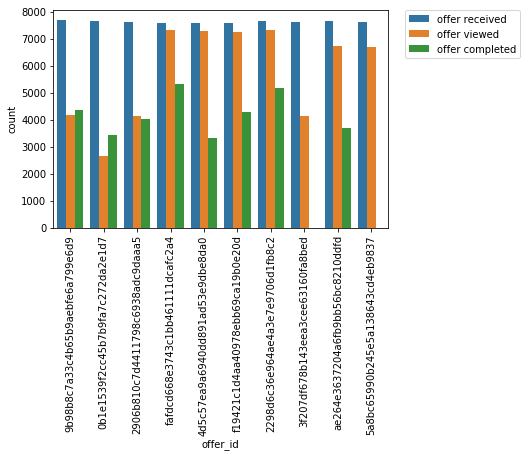

In [26]:
sb.countplot(data=transcript[transcript['event'].str.contains('offer')]
             , x='offer_id', hue='event');
plt.xticks(rotation = 90);
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.);

In [27]:
def plot_grouped_bar(value_cols, data = transcript[transcript['event'] != 'transaction'] ,group_by_col = 'event'):
    
    if group_by_col not in value_cols:
        value_cols.append(group_by_col)
        
    sums = pd.DataFrame(data[value_cols].groupby(group_by_col).sum())
    sums[group_by_col]=sums.index
    
    value_cols.remove(group_by_col)
    
    sums_melted= pd.melt(sums, id_vars=group_by_col, value_vars = value_cols)
    sums_melted.sort_values(by='value', ascending=False, inplace=True)
        
    sb.barplot(data=sums_melted
             , x='variable', hue=group_by_col, y='value');
    plt.xticks(rotation = 90);
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.);

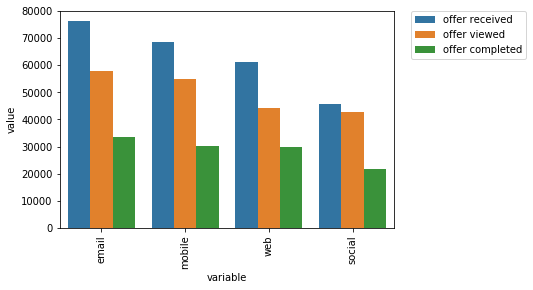

In [28]:
plot_grouped_bar(['web','email','mobile','social'])

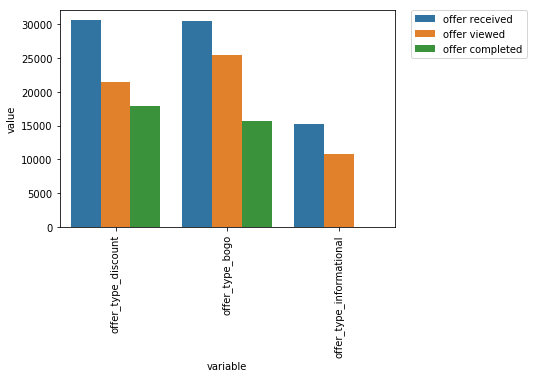

In [29]:
plot_grouped_bar(['offer_type_bogo','offer_type_discount','offer_type_informational'])

In [30]:
#Check if people receive an offer more than once
transcript.groupby(['person', 'offer_id']).sum()['offer_received'].max()

5.0

In [31]:
# create 'offer valid until' data in transcript
for offer in portfolio.iterrows():
    offer_id = offer[1]['id']
    offer_validity = offer[1]['duration']
    transcript.loc[(transcript['offer_id'] == offer_id) 
                  & (transcript['offer_received'] == 1), 'valid_until'] = transcript['time'] + offer_validity 


The following cells take a very long time to run. I have saved the output of the following 11 cells as transcript_cleanedv2.csv. You can skip these cells and load that to save time. 

In [ ]:
#create 'during validity' data for offer completed and transactions
valid_offers = transcript[transcript['offer_received'] ==1][['person', 'offer_id', 'time', 'valid_until']]
transcript.loc[transcript['offer_received'] == 0, 'valid_until'] == np.nan
i = 0
cnt = 0

for row in valid_offers.iterrows():
    if i == 1000:
        cnt += i
        i = 0
        print(cnt)
    start_day = row[1]['time']
    end_day = row[1]['valid_until']
    person = row[1]['person']
    offer_id = row[1]['offer_id']
    valid_days = np.arange(start_day, end_day+1)

    transcript.loc[(transcript['person'] == person)
                  &((transcript['offer_id'] == offer_id)
                    |(transcript['offer_id'] == 0))
                  &(transcript['time'] >= valid_days[0])
                  &(transcript['time'] <= valid_days[-1]), 'during_offer'] =1
    transcript.loc[(transcript['during_offer'] == 1)
                   &(transcript['valid_until'].isna()), 'valid_until'] = end_day

    i +=1
    
transcript.to_csv(path_or_buf='transcript_cleaned')

In [ ]:
#changes transcript dataframe to the one that was saved in the above cell. This just saves time when starting the workbook fresh.
transcript = pd.read_csv('transcript_cleaned')

In [ ]:
#Create 'Customer Aware' data to show if a customer has viewed an offer before completing an offer, or making a transaction
valid_offers = transcript[(transcript['during_offer'] ==1)
                         & (transcript['offer_viewed'] ==1)][['person', 'time', 'valid_until']]

i = 0
cnt = 0

for row in valid_offers.iterrows():
    if i == 1000:
        cnt += i
        i = 0
        print(cnt)
    start_day = row[1]['time']
    end_day = row[1]['valid_until']
    person = row[1]['person']
    valid_days = np.arange(start_day, end_day+1)
    transcript.loc[(transcript['person'] == person)
                  &(transcript['time'] >= valid_days[0])
                  &(transcript['time'] <= valid_days[-1]), 'person_aware'] =1
    i+=1


In [ ]:
transcript.groupby('person_aware').mean()

In [ ]:
# Find people who completed an offer they were aware of, but didn't complete during validity period
transcript.fillna(0, inplace = True)
transcript[(transcript['person_aware'] == 1)
          & (transcript['during_offer'] == 0)]

In [ ]:
#Investigate specific person to find out in what circumstances it happens
transcript[transcript['person'] == 'd682f4b1e4524836aa66ba7d5e6629b7']

Looking at the above dataframe we can see that sometimes a user completes an offer they were aware of, but didn't complete it udring the validity period of the offer. For these I do not want to count them as being aware of the offer when they complete it, as they will also be aware that their completion is outside of the validity period, so the offer is no longer valid. 

In [ ]:
transcript.loc[(transcript['person_aware'] == 1)
          & (transcript['during_offer'] == 0), 'person_aware'] = 0

In [ ]:
## add offer code to transactions that were knowingly completed within an offer.

#get all transactions where person was aware
valid_offers = transcript[(transcript['event'] == 'transaction')
                         & (transcript['person_aware'] ==1)][['person', 'time', 'valid_until']]
print(valid_offers.shape[0])
i = 0
cnt = 0
for row in valid_offers.iterrows():
    if i == 1000:
        cnt += i
        i = 0
        print(cnt)
    transaction_row = row[1].name
    person = transcript.iloc[transaction_row]['person']
    valid_until = transcript.iloc[transaction_row]['valid_until']
    #get offer_id from the 'offer viewed' event that shares the same valid until as the transaction
    offer_row = transcript[(transcript['person'] == person)
                & (transcript['valid_until'] == valid_until)
                & (transcript['event'] == 'offer viewed')].index[0]
    offer_id = transcript.iloc[offer_row]['offer_id']
    # set transaction offer_id to the offer viewed offer_id
    transcript.iloc[transaction_row, transcript.columns.get_loc('offer_id')] = offer_id
    i+=1
transcript.to_csv(path_or_buf='transcript_cleanedv2')

In [32]:
transcript = pd.read_csv('transcript_cleanedv2')

In [33]:
#drop offer information and re-add it so that we have this on the transaction items that now have an offer id
transcript.drop(['web', 'email','mobile', 'social','offer_type_bogo','offer_type_discount', 'offer_type_informational']
              ,axis=1, inplace = True)
transcript = transcript.join(portfolio[['id', 'web', 'email', 
                                        'mobile', 'social','offer_type_bogo', 
                                        'offer_type_discount', 'offer_type_informational']]
                             .set_index('id'), on='offer_id')

In [34]:
#drop offers that were completed after the validity period
transcript.drop(transcript[(transcript['offer_completed'] == 1)
                           &(transcript['during_offer'] ==0)].index, inplace=True)

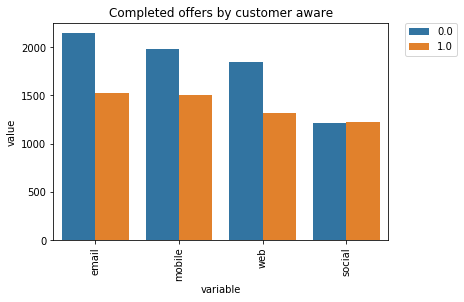

In [35]:
plot_grouped_bar(['web','email', 'mobile', 'social'],
                data = transcript[transcript['offer_completed']==1],
                group_by_col = 'person_aware')
plt.title('Completed offers by customer aware');

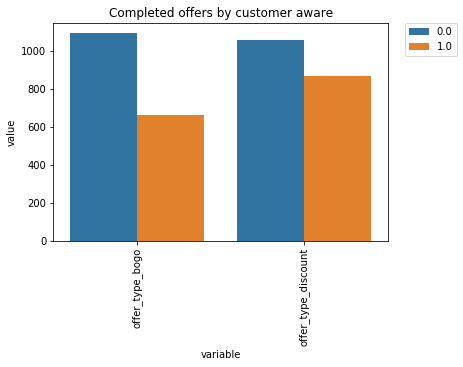

In [36]:
plot_grouped_bar(['offer_type_bogo','offer_type_discount'],
                data = transcript[transcript['offer_completed']==1],
                group_by_col = 'person_aware')
plt.title('Completed offers by customer aware');

In [37]:
#Caclculate how long is left in an offer when the person views it.
transcript.loc[(transcript['offer_viewed'] ==1)
              &(transcript['during_offer'] == 1),
              'days_left_in_offer'] = transcript['valid_until'] - transcript['time']
#Double check that we are only considering an offer as viewed if it's during the validity period. 
#We don't want a negative number!
transcript['days_left_in_offer'].min()

1.0

Text(0,0.5,'Transaction Amount')

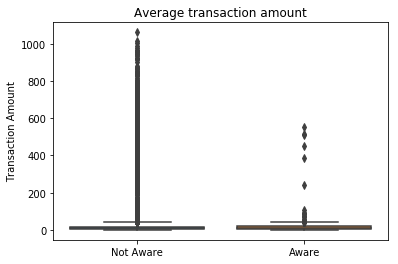

In [38]:
sb.boxplot(data=transcript[transcript['event']=='transaction'], x='person_aware', y='purchase_amount');
plt.title('Average transaction amount');
plt.xlabel('')
plt.xticks([0,1],('Not Aware', 'Aware'));
plt.ylabel('Transaction Amount')

In [39]:
transcript = transcript[transcript['purchase_amount'] < transcript['purchase_amount'].quantile(0.99)]

Text(0,0.5,'Transaction Amount')

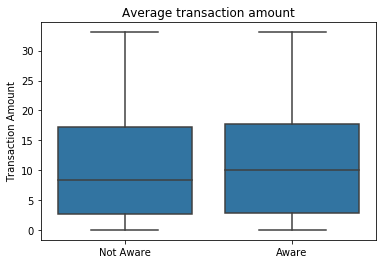

In [40]:
transactions = transcript[transcript['event'] == 'transaction']
transactions = transactions[transactions['purchase_amount'] < transactions['purchase_amount'].quantile(0.99)]
sb.boxplot(data=transactions[transactions['event']=='transaction'], x='person_aware', y='purchase_amount',
          color=sb.color_palette()[0]);
plt.title('Average transaction amount');
plt.xlabel('')
plt.xticks([0,1],('Not Aware', 'Aware'));
plt.ylabel('Transaction Amount')


In [41]:
#perform students T test to see if there is significant difference between the 2 purchase amounts
person_aware = transactions[transactions['person_aware'] == 1]['purchase_amount']
person_not_aware = transactions[transactions['person_aware'] == 0]['purchase_amount']
result = stats.ttest_ind(person_not_aware, person_aware)
print(result[1])

3.52811329655e-06


In [80]:
def calculate_spend_stats_by_offer(df, offer_col, prefix, n_days = transcript['time'].max()):
    #get transactions just related to this offer type
    offer_df = transcript[transcript[offer_col] ==1]
    #calculate total number of days each person is aware of an offer
    df[prefix+'_offer_days'] = offer_df.groupby(by='person').sum()['days_left_in_offer']
    
    #calculate spend when person is aware of the offer
    in_offer_purchases = offer_df[(offer_df['event'] == 'transaction')
                               &(offer_df['person_aware'] == 1)]
    df[prefix+'_offer_spend'] = in_offer_purchases.groupby(by=['person']).sum()['purchase_amount']
    df['daily_'+prefix+'_offer_spend'] = df[prefix+'_offer_spend'] / df[prefix+'_offer_days']
    
    #calculate number of transactions when person is aware of an offer
    df[prefix+'_offer_transactions'] = in_offer_purchases.groupby(by=['person']).count()['purchase_amount']
    df['daily_'+prefix+'_offer_transactions'] = df[prefix+'_offer_transactions'] / df[prefix+'_offer_days']
    

In [81]:
#Calculate the average spend per person, per day during and out of offer validity (validity assumes that the person
#aware of the offer, and that it is during the validity period of the offer.)
n_days = transcript['time'].max()
spend_per_customer = pd.DataFrame()

#calculate total spend per customer, regardless of if purchase is in an offer or not
spend_per_customer['total_spend'] = transcript.groupby(by='person').sum()['purchase_amount']
spend_per_customer['spend_per_day'] = transcript.groupby(by='person').sum()['purchase_amount']/n_days

#calculate total transactions, and transactions per day
spend_per_customer['total_transactions'] = transcript[transcript['event'] == 'transaction'].groupby(by='person').count()['purchase_amount']
spend_per_customer['daily_transactions'] = spend_per_customer['total_transactions']/n_days

#calculate total number of days each person is aware of an offer
spend_per_customer['offer_days'] = transcript.groupby(by='person').sum()['days_left_in_offer']
spend_per_customer.loc[spend_per_customer['offer_days'] == 0, 'offer_days'] = np.nan

#calculate total and daily spend during offers that the person is aware of
in_offer_purchases = transcript[(transcript['event'] == 'transaction')
                               &(transcript['person_aware'] == 1)]
spend_per_customer['offer_spend'] = in_offer_purchases.groupby(by=['person']).sum()['purchase_amount']
spend_per_customer['daily_offer_spend'] = spend_per_customer['offer_spend'] / spend_per_customer['offer_days']
spend_per_customer['total_offer_transactions'] = in_offer_purchases.groupby(by='person').count()['purchase_amount']
spend_per_customer['daily_offer_transactions'] = spend_per_customer['total_offer_transactions'] / spend_per_customer['offer_days']

#calculate total and daily spend when either there is no offer, or the person is not aware of an offer
no_offer_purchases = transcript[(transcript['event'] == 'transaction')
                               &(transcript['person_aware'] == 0)]
spend_per_customer['no_offer_spend'] = no_offer_purchases.groupby(by=['person']).sum()['purchase_amount']
spend_per_customer['daily_no_offer_spend'] = spend_per_customer['no_offer_spend'] / (n_days - spend_per_customer['offer_days'])
spend_per_customer['total_no_offer_transactions'] = no_offer_purchases.groupby(by='person').count()['purchase_amount']
spend_per_customer['daily_no_offer_transactions'] = spend_per_customer['total_no_offer_transactions'] / (n_days - spend_per_customer['offer_days'])

#Add columns for offer types
calculate_spend_stats_by_offer(spend_per_customer, 'offer_type_bogo', 'bogo')
calculate_spend_stats_by_offer(spend_per_customer, 'offer_type_discount', 'disc')
calculate_spend_stats_by_offer(spend_per_customer, 'offer_type_informational', 'info')

In [82]:
spend_per_customer.describe()

,total_spend,spend_per_day,total_transactions,daily_transactions,offer_days,offer_spend,daily_offer_spend,total_offer_transactions,daily_offer_transactions,no_offer_spend,...,disc_offer_days,disc_offer_spend,daily_disc_offer_spend,disc_offer_transactions,daily_disc_offer_transactions,info_offer_days,info_offer_spend,daily_info_offer_spend,info_offer_transactions,daily_info_offer_transactions
count,17000.000000,17000.000000,16566.000000,16566.000000,10886.000000,2708.000000,2708.000000,2708.000000,2708.000000,16560.000000,...,14945.000000,1431.000000,1431.000000,1431.000000,1431.000000,10547.000000,283.000000,283.000000,283.000000,283.000000
mean,86.502188,0.121152,8.220633,0.011513,8.252894,13.361141,2.176304,1.159527,0.198132,86.615654,...,3.230780,13.223445,2.655147,1.113906,0.227821,0.632028,12.191272,3.511675,1.007067,0.298239
std,78.575817,0.110050,5.007502,0.007013,5.670049,11.652300,3.706097,0.407305,0.231400,76.124137,...,4.956266,11.060042,4.553492,0.353240,0.276849,1.433225,9.704579,2.722102,0.083917,0.056156
min,0.000000,0.000000,1.000000,0.001401,1.000000,0.050000,0.003333,1.000000,0.021739,0.050000,...,0.000000,0.050000,0.005000,1.000000,0.031250,0.000000,0.050000,0.016667,1.000000,0.100000
25%,21.065000,0.029503,4.000000,0.005602,4.000000,3.367500,0.432476,1.000000,0.083333,22.397500,...,0.000000,3.415000,0.456333,1.000000,0.100000,0.000000,3.210000,0.974583,1.000000,0.250000
50%,62.330000,0.087297,7.000000,0.009804,7.000000,11.125000,1.196397,1.000000,0.133333,64.335000,...,0.000000,11.930000,1.313000,1.000000,0.142857,0.000000,10.980000,3.080000,1.000000,0.333333
75%,135.012500,0.189093,11.000000,0.015406,11.000000,20.032500,2.398669,1.000000,0.200000,134.080000,...,7.000000,19.700000,2.612143,1.000000,0.200000,0.000000,19.170000,5.560000,1.000000,0.333333
max,497.980000,0.697451,36.000000,0.050420,46.000000,102.110000,34.830000,4.000000,1.000000,497.980000,...,34.000000,78.820000,34.830000,4.000000,1.000000,14.000000,64.100000,10.700000,2.000000,0.333333


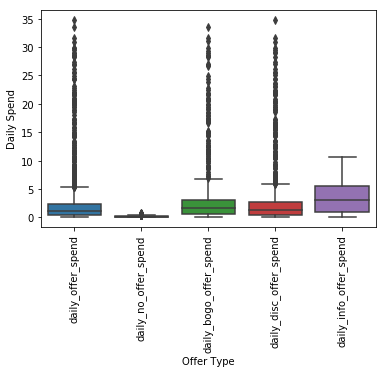

In [83]:
transaction_amounts = spend_per_customer[['daily_offer_spend','daily_no_offer_spend','daily_bogo_offer_spend',
                                          'daily_disc_offer_spend', 'daily_info_offer_spend']]
sb.boxplot(x="variable",y="value",data=pd.melt(transaction_amounts));
plt.xticks(rotation = 90);
plt.ylabel('Daily Spend');
plt.xlabel('Offer Type');

In [84]:
#perform students T test to see if there is significant difference between the 2 purchase amounts
offer_transactions = spend_per_customer['daily_offer_transactions'].dropna()
no_offer_transactions = spend_per_customer['daily_no_offer_transactions'].dropna()
result = stats.ttest_ind(offer_transactions, no_offer_transactions)
print(result[1])

0.0


In [85]:
spend_per_customer[['daily_offer_transactions','daily_no_offer_transactions']].dropna().mean()

daily_offer_transactions       0.198389
daily_no_offer_transactions    0.015011
dtype: float64

In [86]:
1- spend_per_customer.isna().mean()

total_spend                      1.000000
spend_per_day                    1.000000
total_transactions               0.974471
daily_transactions               0.974471
offer_days                       0.640353
offer_spend                      0.159294
daily_offer_spend                0.159294
total_offer_transactions         0.159294
daily_offer_transactions         0.159294
no_offer_spend                   0.974118
daily_no_offer_spend             0.623412
total_no_offer_transactions      0.974118
daily_no_offer_transactions      0.623412
bogo_offer_days                  0.881882
bogo_offer_spend                 0.069000
daily_bogo_offer_spend           0.069000
bogo_offer_transactions          0.069000
daily_bogo_offer_transactions    0.069000
disc_offer_days                  0.879118
disc_offer_spend                 0.084176
daily_disc_offer_spend           0.084176
disc_offer_transactions          0.084176
daily_disc_offer_transactions    0.084176
info_offer_days                  0

In [87]:
daily_transactions = spend_per_customer.join(profile.set_index('id'),on='person')[['age','gender','became_member_on','income','offer_days',
                                                                                   'daily_transactions','daily_offer_transactions', 'daily_no_offer_transactions',
                                                                                   'daily_bogo_offer_transactions', 'daily_disc_offer_transactions',
                                                                                   'daily_info_offer_transactions']]

nan_vals = {"daily_offer_transactions":0,
           "daily_no_offer_transactions":0}

daily_transactions.fillna(value=nan_vals, inplace=True)
daily_transactions['daily_diff'] = daily_transactions['daily_offer_transactions'] - daily_transactions['daily_no_offer_transactions'] 
daily_transactions['daily_bogo_diff'] = daily_transactions['daily_bogo_offer_transactions'] - daily_transactions['daily_no_offer_transactions'] 
daily_transactions['daily_disc_diff'] = daily_transactions['daily_disc_offer_transactions'] - daily_transactions['daily_no_offer_transactions'] 
daily_transactions['daily_info_diff'] = daily_transactions['daily_info_offer_transactions'] - daily_transactions['daily_no_offer_transactions'] 

In [88]:
daily_transactions['became_member_on'] = daily_transactions['became_member_on'].apply(str)
daily_transactions['joined_year'] = daily_transactions['became_member_on'].str[:4]

In [89]:
def plot_daily_transaction_differences(diff_col, title, data):
    fig, axs = plt.subplots(2,2, sharey=True)
    fig.set_size_inches(15, 7.5)
    fig.suptitle(title);
    groups = data.groupby('gender')

    for name, group in groups:
        axs[0,0].plot(group['age'], group[diff_col], marker='.', linestyle='', label=name);
        axs[0,0].set_title('Difference by age and gender');
        axs[0,1].plot(group['income'], group[diff_col], marker='.', linestyle='', label=name);
        axs[0,1].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.);
        axs[0,1].set_title('Difference by income and gender');
    
    groups = data.groupby('joined_year')
    for name, group in groups:
        axs[1,0].plot(group['age'], group[diff_col], marker='.', linestyle='', label=name);
        axs[1,0].set_xlabel('Age');
        axs[1,0].set_title('Difference by age and year joined');
        axs[1,1].plot(group['income'], group[diff_col], marker='.', linestyle='', label=name);
        axs[1,1].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.);
        axs[1,1].set_title('Difference by income and year joined');
        axs[1,1].set_xlabel('Income');

    
    fig.text(0.06, 0.5, 'Difference between daily transactions during and out of offer', ha='center', va='center', rotation='vertical')

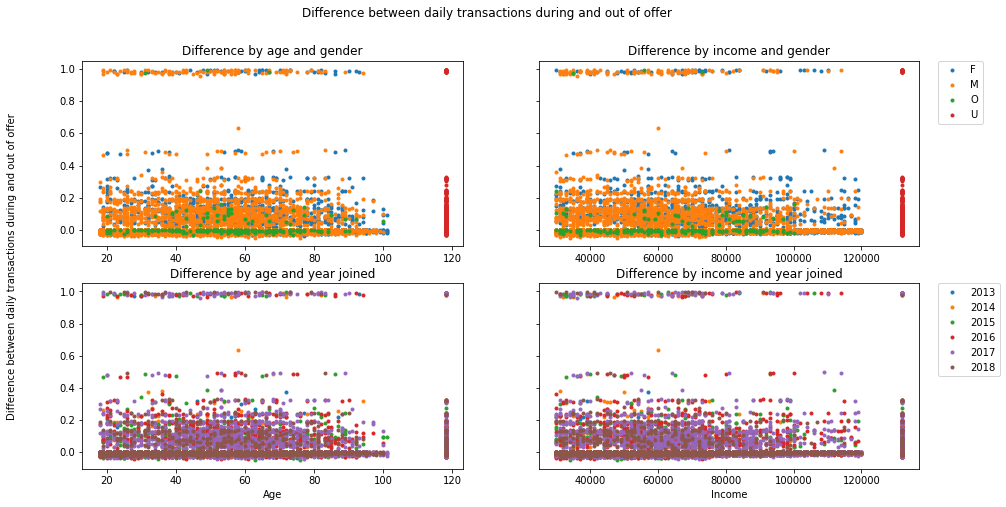

In [90]:
plot_daily_transaction_differences('daily_diff','Difference between daily transactions during and out of offer', daily_transactions)

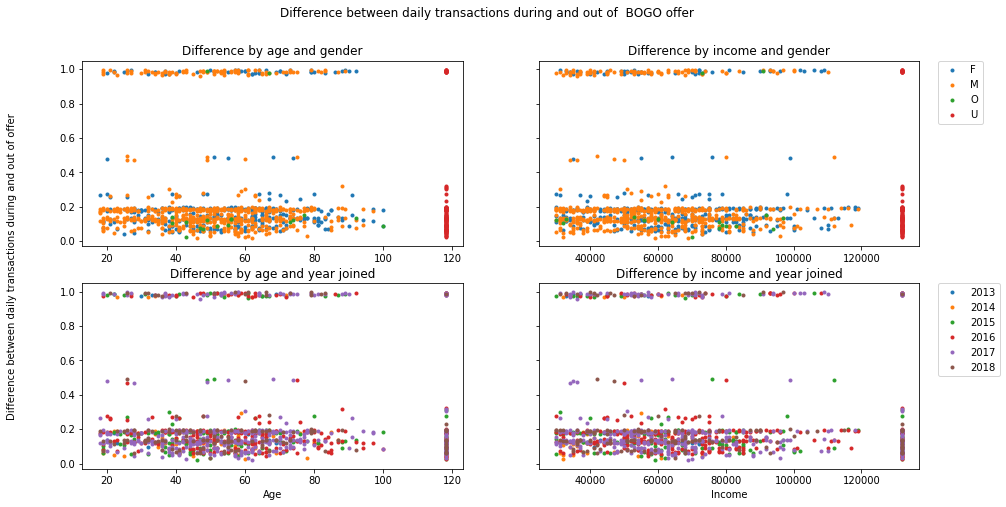

In [91]:
plot_daily_transaction_differences('daily_bogo_diff','Difference between daily transactions during and out of  BOGO offer', daily_transactions)

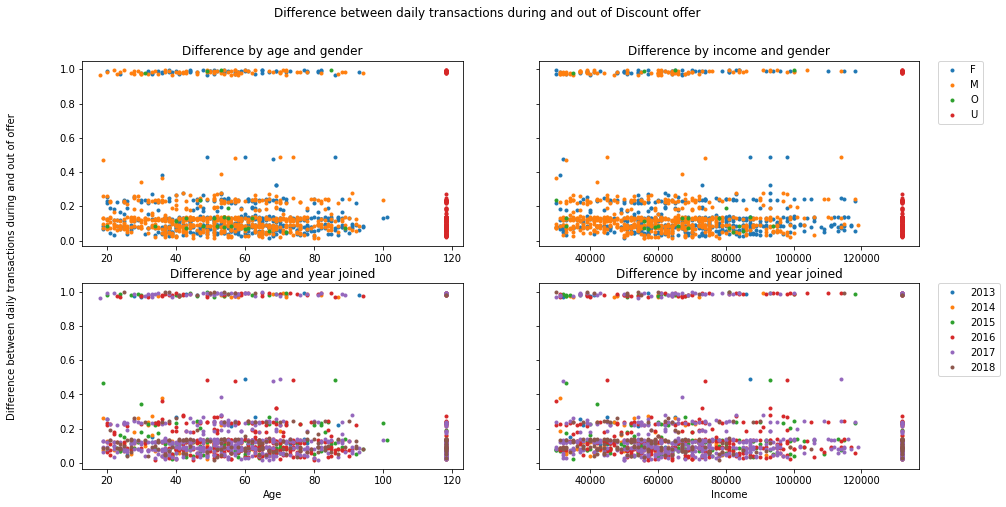

In [92]:
plot_daily_transaction_differences('daily_disc_diff','Difference between daily transactions during and out of Discount offer', daily_transactions)

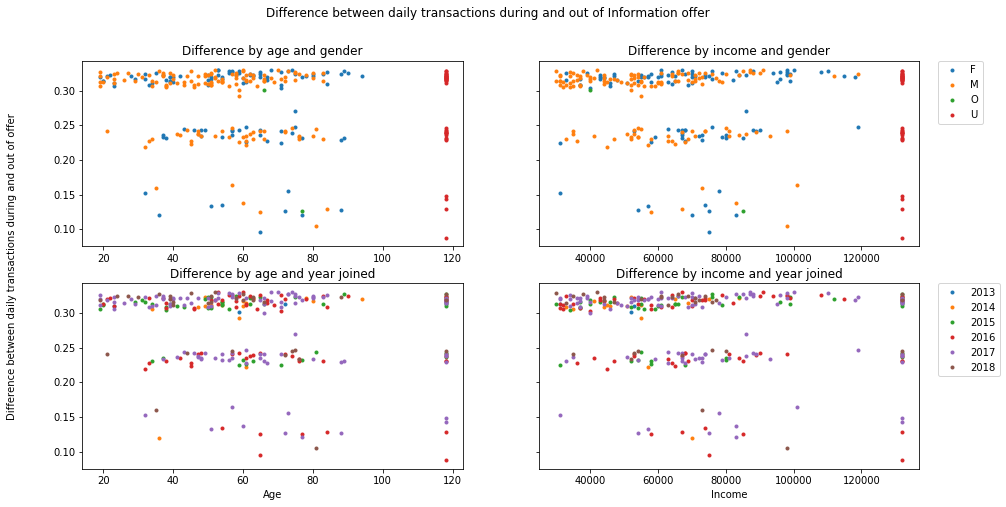

In [110]:
plot_daily_transaction_differences('daily_info_diff','Difference between daily transactions during and out of Information offer', daily_transactions)

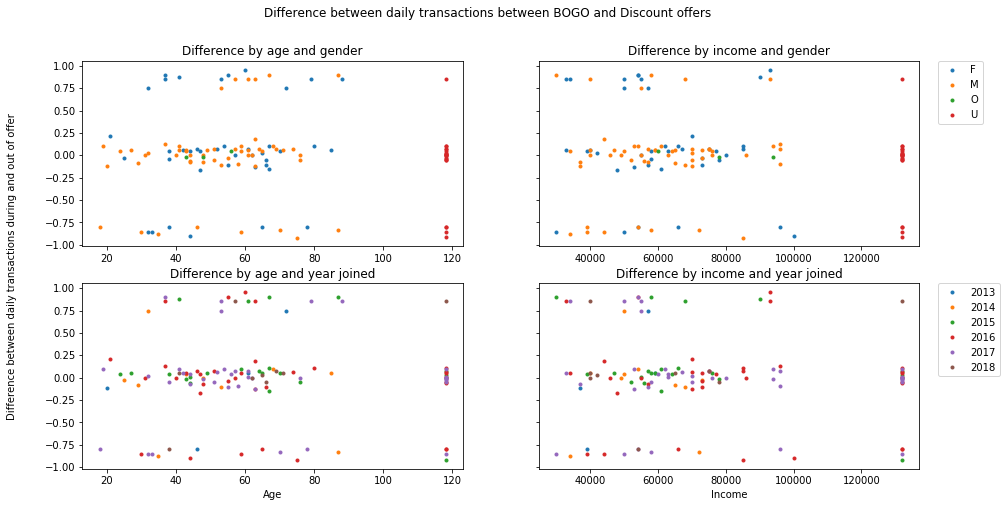

In [111]:
daily_transactions['bogo_disc_daily_diff'] = daily_transactions['daily_bogo_offer_transactions'] - daily_transactions['daily_disc_offer_transactions']
plot_daily_transaction_differences('bogo_disc_daily_diff','Difference between daily transactions between BOGO and Discount offers', daily_transactions)

## What does this show us?
To be honest it doesn't show a lot. we can see that some users respond better to BOGO offers, and some discount offers, but that most respond equally to both. There is no correlation between daily transactions during an offer with age, gender, income or year joined the app. All we can really see is that a few users respond very positively, and make a purchase almost every day they are aware of an offer, whereas the majority increase their purchase rate slightly.

Below I will check the same things, but against the medium the offer was delivered through to see if this has an impact on whether different customer groups respond differently.

In [112]:
calculate_spend_stats_by_offer(spend_per_customer, 'web', 'web')
calculate_spend_stats_by_offer(spend_per_customer, 'mobile', 'mobile')
calculate_spend_stats_by_offer(spend_per_customer, 'social', 'social')

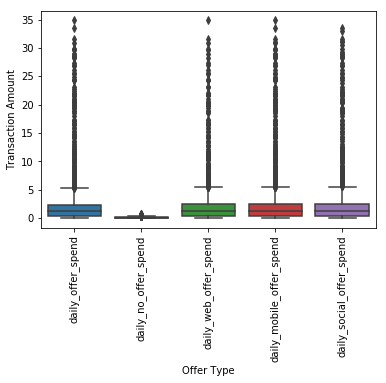

In [113]:
transaction_amounts = spend_per_customer[['daily_offer_spend','daily_no_offer_spend','daily_web_offer_spend',
                                          'daily_mobile_offer_spend', 'daily_social_offer_spend']]
sb.boxplot(x="variable",y="value",data=pd.melt(transaction_amounts));
plt.xticks(rotation = 90);
plt.ylabel('Transaction Amount');
plt.xlabel('Offer Type');

In [114]:
medium_transactions = spend_per_customer.join(profile.set_index('id'),on='person')[['age','gender','became_member_on','income','offer_days',
                                                                                   'daily_transactions','daily_offer_transactions', 'daily_no_offer_transactions',
                                                                                   'daily_web_offer_transactions', 'daily_mobile_offer_transactions',
                                                                                   'daily_social_offer_transactions']]


medium_transactions.fillna(value=0, inplace=True)
medium_transactions['daily_diff'] = medium_transactions['daily_offer_transactions'] - medium_transactions['daily_no_offer_transactions'] 
medium_transactions['daily_web_diff'] = medium_transactions['daily_web_offer_transactions'] - medium_transactions['daily_no_offer_transactions'] 
medium_transactions['daily_mobile_diff'] = medium_transactions['daily_mobile_offer_transactions'] - medium_transactions['daily_no_offer_transactions'] 
medium_transactions['daily_social_diff'] = medium_transactions['daily_social_offer_transactions'] - medium_transactions['daily_no_offer_transactions'] 
medium_transactions['became_member_on'] = medium_transactions['became_member_on'].apply(str)
medium_transactions['joined_year'] = medium_transactions['became_member_on'].str[:4]

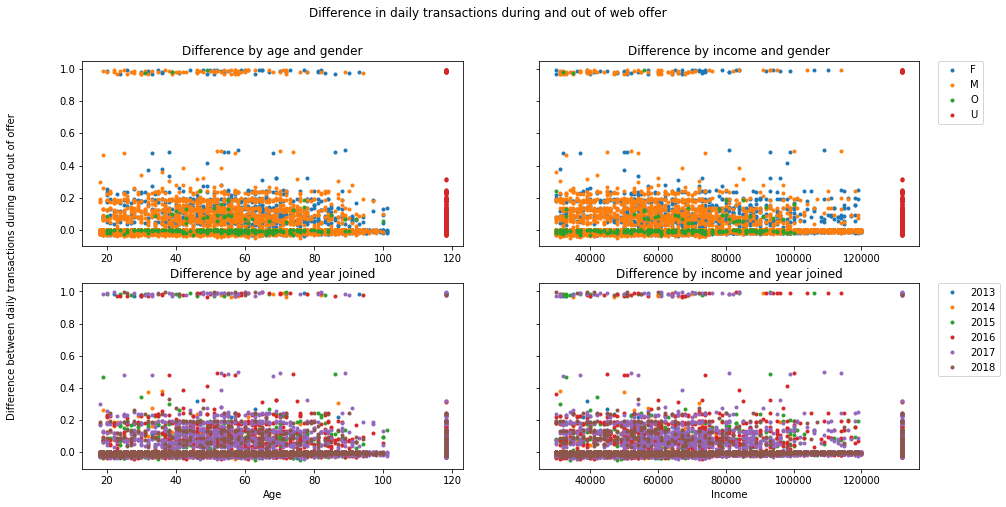

In [115]:
plot_daily_transaction_differences('daily_web_diff','Difference in daily transactions during and out of web offer', medium_transactions)

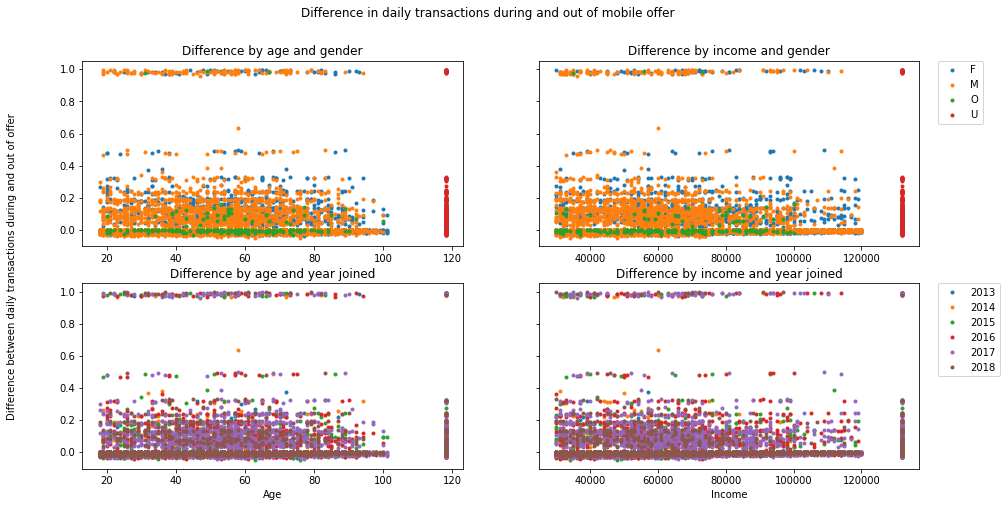

In [116]:
plot_daily_transaction_differences('daily_mobile_diff','Difference in daily transactions during and out of mobile offer', medium_transactions)

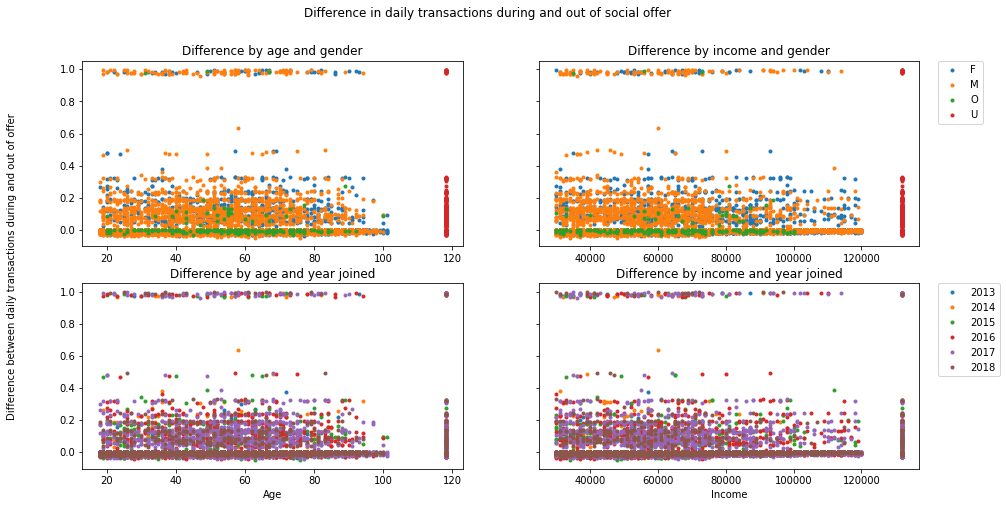

In [117]:
plot_daily_transaction_differences('daily_social_diff','Difference in daily transactions during and out of social offer', medium_transactions)

## Grouping by age

Again we can't really tell much from the above. I will now visualise the transactions by age group to see if that offers any further insights into the data. As there is an imbalance of users of each age, I will measure everything as an average per person. Otherwise we would see that a the ages with the most users would most likely have the higher number of transactions.

In [119]:
trans_totals = spend_per_customer[['total_transactions','total_offer_transactions','total_no_offer_transactions',
                                  'bogo_offer_transactions','disc_offer_transactions','info_offer_transactions',
                                  'web_offer_transactions','mobile_offer_transactions','social_offer_transactions']].fillna(0)
trans_totals = trans_totals.join(profile.set_index('id'),on='person')
trans_totals.head()

,total_transactions,total_offer_transactions,total_no_offer_transactions,bogo_offer_transactions,disc_offer_transactions,info_offer_transactions,web_offer_transactions,mobile_offer_transactions,social_offer_transactions,age,became_member_on,gender,income
person,,,,,,,,,,,,,
0009655768c64bdeb2e877511632db8f,8.0,0.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,33,20170421,M,72000.0
00116118485d4dfda04fdbaba9a87b5c,3.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,118,20180425,U,132000.0
0011e0d4e6b944f998e987f904e8c1e5,5.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,40,20180109,O,57000.0
0020c2b971eb4e9188eac86d93036a77,8.0,0.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,59,20160304,F,90000.0
0020ccbbb6d84e358d3414a3ff76cffd,12.0,0.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0,24,20161111,F,60000.0


In [120]:
grouped_trans_totals = trans_totals.groupby(by='age').sum()
age_counts = trans_totals['age'].value_counts()
grouped_trans_totals['count'] = age_counts
grouped_trans_totals['age'] = grouped_trans_totals.index
grouped_trans_totals['transactions_pp'] = grouped_trans_totals['total_transactions']/grouped_trans_totals['count']
grouped_trans_totals['offer_transactions_pp'] = grouped_trans_totals['total_offer_transactions']/grouped_trans_totals['count']
grouped_trans_totals['no_offer_transactions_pp'] = grouped_trans_totals['total_no_offer_transactions']/grouped_trans_totals['count']
grouped_trans_totals['bogo_transactions_pp'] = grouped_trans_totals['bogo_offer_transactions']/grouped_trans_totals['count']
grouped_trans_totals['disc_transactions_pp'] = grouped_trans_totals['disc_offer_transactions']/grouped_trans_totals['count']
grouped_trans_totals['info_transactions_pp'] = grouped_trans_totals['info_offer_transactions']/grouped_trans_totals['count']
grouped_trans_totals['web_transactions_pp'] = grouped_trans_totals['web_offer_transactions']/grouped_trans_totals['count']
grouped_trans_totals['mobile_transactions_pp'] = grouped_trans_totals['mobile_offer_transactions']/grouped_trans_totals['count']
grouped_trans_totals['social_transactions_pp'] = grouped_trans_totals['social_offer_transactions']/grouped_trans_totals['count']

grouped_trans_totals.head()

,total_transactions,total_offer_transactions,total_no_offer_transactions,bogo_offer_transactions,disc_offer_transactions,info_offer_transactions,web_offer_transactions,mobile_offer_transactions,social_offer_transactions,became_member_on,...,age,transactions_pp,offer_transactions_pp,no_offer_transactions_pp,bogo_transactions_pp,disc_transactions_pp,info_transactions_pp,web_transactions_pp,mobile_transactions_pp,social_transactions_pp
age,,,,,,,,,,,,,,,,,,,,,
18,695.0,8.0,687.0,7.0,1.0,0.0,5.0,8.0,8.0,1411600598,...,18,9.928571,0.114286,9.814286,0.100000,0.014286,0.000000,0.071429,0.114286,0.114286
19,1364.0,30.0,1334.0,15.0,10.0,5.0,17.0,30.0,27.0,2722578836,...,19,10.103704,0.222222,9.881481,0.111111,0.074074,0.037037,0.125926,0.222222,0.200000
20,1360.0,32.0,1328.0,12.0,17.0,3.0,23.0,32.0,30.0,2722576028,...,20,10.074074,0.237037,9.837037,0.088889,0.125926,0.022222,0.170370,0.237037,0.222222
21,1456.0,25.0,1431.0,13.0,9.0,3.0,14.0,25.0,23.0,2823224036,...,21,10.400000,0.178571,10.221429,0.092857,0.064286,0.021429,0.100000,0.178571,0.164286
22,1215.0,21.0,1194.0,9.0,11.0,1.0,16.0,21.0,18.0,2641998809,...,22,9.274809,0.160305,9.114504,0.068702,0.083969,0.007634,0.122137,0.160305,0.137405


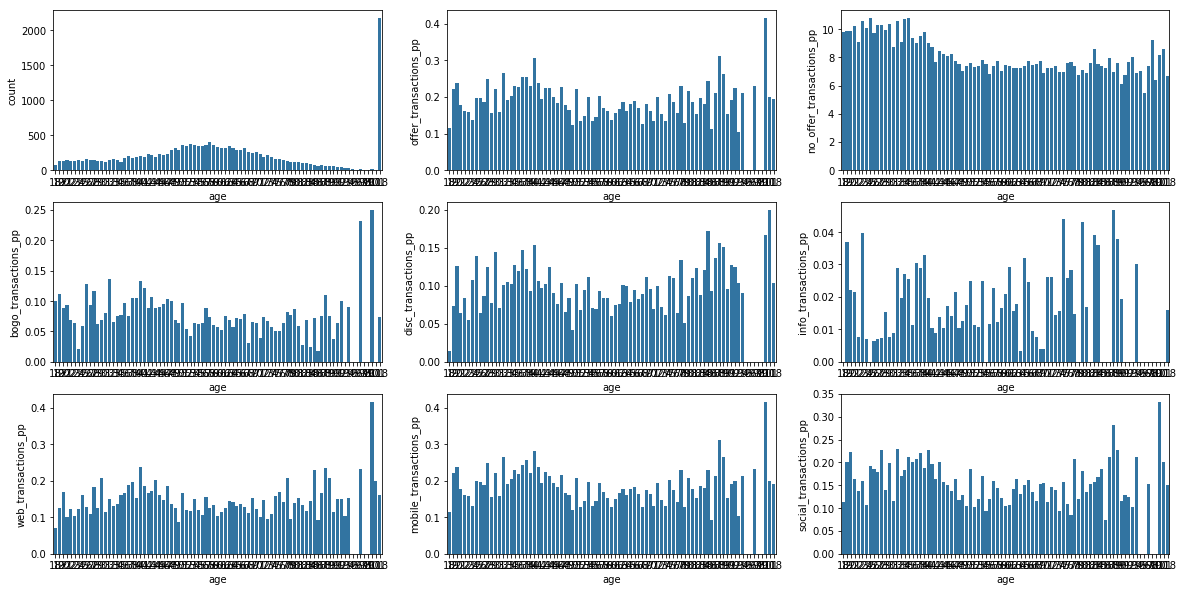

In [121]:
fig, axs = plt.subplots(3,3)
fig.set_size_inches(20,10)

sb.barplot(x='age',y='count',data=grouped_trans_totals,color=sb.color_palette()[0], ax = axs[0,0]);
sb.barplot(x='age',y='offer_transactions_pp',data=grouped_trans_totals,color=sb.color_palette()[0], ax = axs[0,1]);
sb.barplot(x='age',y='no_offer_transactions_pp',data=grouped_trans_totals,color=sb.color_palette()[0], ax = axs[0,2]);
sb.barplot(x='age',y='bogo_transactions_pp',data=grouped_trans_totals,color=sb.color_palette()[0], ax = axs[1,0]);
sb.barplot(x='age',y='disc_transactions_pp',data=grouped_trans_totals,color=sb.color_palette()[0], ax = axs[1,1]);
sb.barplot(x='age',y='info_transactions_pp',data=grouped_trans_totals,color=sb.color_palette()[0], ax = axs[1,2]);
sb.barplot(x='age',y='web_transactions_pp',data=grouped_trans_totals,color=sb.color_palette()[0], ax = axs[2,0]);
sb.barplot(x='age',y='mobile_transactions_pp',data=grouped_trans_totals,color=sb.color_palette()[0], ax = axs[2,1]);
sb.barplot(x='age',y='social_transactions_pp',data=grouped_trans_totals,color=sb.color_palette()[0], ax = axs[2,2]);

## Grouping by total transactions rather than daily.
Above I have calculated the daily transaction amounts per user of each age. This is perhaps not the best way to visualise this data as some age groups may be more aware of offers, i.e. they have more "offer days" in which to make a purchase, this in turn would drive down their transactions per offer day as opposed to a group that were only aware of an offer for 1 day. 

In [122]:
trans_daily = spend_per_customer[['daily_transactions','daily_offer_transactions','daily_no_offer_transactions',
                                  'daily_bogo_offer_transactions','daily_disc_offer_transactions','daily_info_offer_transactions',
                                  'daily_web_offer_transactions','daily_mobile_offer_transactions','daily_social_offer_transactions']].fillna(0)
trans_daily = trans_daily.join(profile.set_index('id'),on='person')
trans_daily.head()

,daily_transactions,daily_offer_transactions,daily_no_offer_transactions,daily_bogo_offer_transactions,daily_disc_offer_transactions,daily_info_offer_transactions,daily_web_offer_transactions,daily_mobile_offer_transactions,daily_social_offer_transactions,age,became_member_on,gender,income
person,,,,,,,,,,,,,
0009655768c64bdeb2e877511632db8f,0.011204,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,33,20170421,M,72000.0
00116118485d4dfda04fdbaba9a87b5c,0.004202,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,118,20180425,U,132000.0
0011e0d4e6b944f998e987f904e8c1e5,0.007003,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,40,20180109,O,57000.0
0020c2b971eb4e9188eac86d93036a77,0.011204,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,59,20160304,F,90000.0
0020ccbbb6d84e358d3414a3ff76cffd,0.016807,0.0,0.017045,0.0,0.0,0.0,0.0,0.0,0.0,24,20161111,F,60000.0


In [123]:
grouped_trans_daily = trans_daily.groupby(by='age').sum()
age_counts = trans_daily['age'].value_counts()
grouped_trans_daily['count'] = age_counts
grouped_trans_daily['age'] = grouped_trans_daily.index
grouped_trans_daily['transactions_pp'] = grouped_trans_daily['daily_transactions']/grouped_trans_daily['count']
grouped_trans_daily['offer_transactions_pp'] = grouped_trans_daily['daily_offer_transactions']/grouped_trans_daily['count']
grouped_trans_daily['no_offer_transactions_pp'] = grouped_trans_daily['daily_no_offer_transactions']/grouped_trans_daily['count']
grouped_trans_daily['bogo_transactions_pp'] = grouped_trans_daily['daily_bogo_offer_transactions']/grouped_trans_daily['count']
grouped_trans_daily['disc_transactions_pp'] = grouped_trans_daily['daily_disc_offer_transactions']/grouped_trans_daily['count']
grouped_trans_daily['info_transactions_pp'] = grouped_trans_daily['daily_info_offer_transactions']/grouped_trans_daily['count']
grouped_trans_daily['web_transactions_pp'] = grouped_trans_daily['daily_web_offer_transactions']/grouped_trans_daily['count']
grouped_trans_daily['mobile_transactions_pp'] = grouped_trans_daily['daily_mobile_offer_transactions']/grouped_trans_daily['count']
grouped_trans_daily['social_transactions_pp'] = grouped_trans_daily['daily_social_offer_transactions']/grouped_trans_daily['count']

grouped_trans_daily.head()

,daily_transactions,daily_offer_transactions,daily_no_offer_transactions,daily_bogo_offer_transactions,daily_disc_offer_transactions,daily_info_offer_transactions,daily_web_offer_transactions,daily_mobile_offer_transactions,daily_social_offer_transactions,became_member_on,...,age,transactions_pp,offer_transactions_pp,no_offer_transactions_pp,bogo_transactions_pp,disc_transactions_pp,info_transactions_pp,web_transactions_pp,mobile_transactions_pp,social_transactions_pp
age,,,,,,,,,,,,,,,,,,,,,
18,0.973389,1.361905,0.526944,1.228571,1.000000,0.000000,0.933333,1.361905,1.361905,1411600598,...,18,0.013906,0.019456,0.007528,0.017551,0.014286,0.000000,0.013333,0.019456,0.019456
19,1.910364,6.392684,1.143904,4.546429,1.471429,1.666667,2.973449,6.392684,5.318442,2722578836,...,19,0.014151,0.047353,0.008473,0.033677,0.010899,0.012346,0.022026,0.047353,0.039396
20,1.904762,5.842216,1.258007,3.138095,4.000000,1.000000,4.797619,5.842216,6.492216,2722576028,...,20,0.014109,0.043276,0.009319,0.023245,0.029630,0.007407,0.035538,0.043276,0.048090
21,2.039216,4.660786,1.124225,2.867857,1.290909,0.916667,2.135354,4.660786,4.285786,2823224036,...,21,0.014566,0.033291,0.008030,0.020485,0.009221,0.006548,0.015253,0.033291,0.030613
22,1.701681,5.377886,1.049120,3.969048,2.131061,0.333333,3.842172,6.286977,5.253968,2641998809,...,22,0.012990,0.041053,0.008009,0.030298,0.016268,0.002545,0.029330,0.047992,0.040107


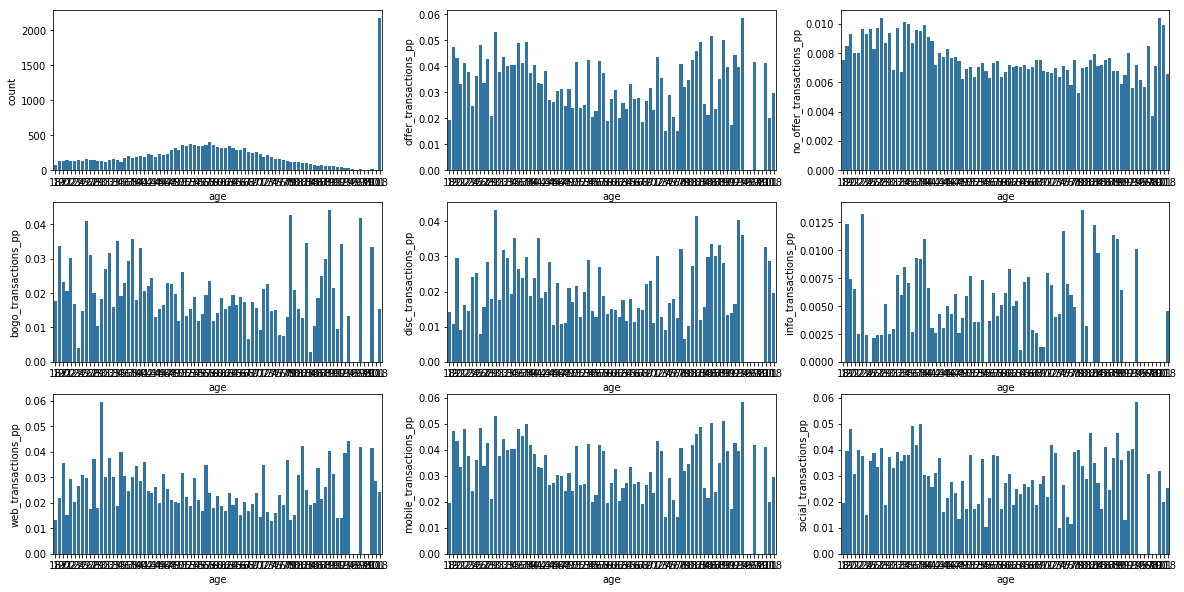

In [124]:
fig, axs = plt.subplots(3,3)
fig.set_size_inches(20,10)

sb.barplot(x='age',y='count',data=grouped_trans_daily,color=sb.color_palette()[0], ax = axs[0,0]);
sb.barplot(x='age',y='offer_transactions_pp',data=grouped_trans_daily,color=sb.color_palette()[0], ax = axs[0,1]);
sb.barplot(x='age',y='no_offer_transactions_pp',data=grouped_trans_daily,color=sb.color_palette()[0], ax = axs[0,2]);
sb.barplot(x='age',y='bogo_transactions_pp',data=grouped_trans_daily,color=sb.color_palette()[0], ax = axs[1,0]);
sb.barplot(x='age',y='disc_transactions_pp',data=grouped_trans_daily,color=sb.color_palette()[0], ax = axs[1,1]);
sb.barplot(x='age',y='info_transactions_pp',data=grouped_trans_daily,color=sb.color_palette()[0], ax = axs[1,2]);
sb.barplot(x='age',y='web_transactions_pp',data=grouped_trans_daily,color=sb.color_palette()[0], ax = axs[2,0]);
sb.barplot(x='age',y='mobile_transactions_pp',data=grouped_trans_daily,color=sb.color_palette()[0], ax = axs[2,1]);
sb.barplot(x='age',y='social_transactions_pp',data=grouped_trans_daily,color=sb.color_palette()[0], ax = axs[2,2]);

## Conclusion

We can prove that offers do have an impact on customer behaviour once a customer is aware of the offer. And we can also show that this is true across user groups, with no discernible impact on uptake once a user is aware of the offer. The next steps following on from these findings would be to ascertain which users responded bet to which medium of delivering an offer. Once we can increase the offer viewed percentage, we would certainly expect to see an uptake in the offers as per the findings from this study.